<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/08_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

Actual Goal: Turn ML research into usable code.
We are going to replicate Vision Transformer (ViT) paper. https://arxiv.org/abs/2010.11929

## 0. Get Setup
We are going to use the code from going_modular (05 notebook).

In [1]:
import torch
import torchvision

torch.__version__,torchvision.__version__

('2.1.0+cu118', '0.16.0+cu118')

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The whole goal is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need the data we have been using so far.

In [4]:
# Download pizza, steak, sushi images from Github
image_path = download_data(source ="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths for training and test
train_dir = image_path /'train'
test_dir = image_path /'test'

## 2. Create Datasets and DataLoaders


### 2.1 Create image size, Batch size and transform (manual)


In [6]:
from going_modular.going_modular import data_setup

IMAGE_SIZE = 224 # can be found at table 3 of the ViT paper.
BATCH_SIZE = 32 # in the paper is 4096, but we do not have that much computing power

# Create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                        transforms.ToTensor()])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

### 2.2 Create DataLoaders


In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader),len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image.

In [8]:
# iterate through the train_dataloader and visualize one single image
# Get the image batch
image_batch , label_batch = next(iter(train_dataloader))

# Get a single image from the batch

image, label = image_batch[0], label_batch[0]

# View the image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

(-0.5, 223.5, 223.5, -0.5)

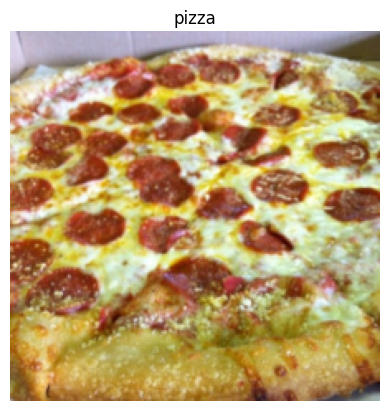

In [9]:
# Plot the image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) # (color_channels, h,w) -> (h,w, color_channels)
plt.title(class_names[label])
plt.axis(False)

### 3. Replicating ViT: Overview

Looking at a whole ML research aper can be intimidating.

So in order to make it more understatable, we break it down into smaller pieces.

* **Inputs** - What goes into the model (in our case, image tensors (batches))
* **Outputs** - What come out of the model/layer/block ? (in our case: Classification labels)
* **Layers** - Takes an input, manipulates it with a function (e.g self-attention)
* **Block** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview: "gathering the pieces"

* Figure 1: Visual overview of the architecture
* 4 equations: Math equations that define the functions of each layer/block
* Table 1: different hyperparameters for the architecture/training.
* Text

#### Figure 1
<img src = "https://drive.google.com/file/d/1g03SePH4WFA6D5x5qVRX8GXJm853wM8U/open?usp=drive_link" alt = 'figure 1'/>

* Embedding = learning representation (random in the beggining and imporve over time)

#### 4 Equations
<img src='https://drive.google.com/file/d/1S7fXVm0WcGvP8znz8mv_S7aOkm9rXF0B/view?usp=drive_link' />

#### Table 1
<img src ='https://drive.google.com/file/d/1Ql-pUCKl49X2Wxo1dNjIb28OFhs-vI4z/view?usp=drive_link' />



### Table 1

There are 3 models presented in the paper:

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers.
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size -the number of hidden units/neurons in the MLP.
* Head - the number of the multi-head self-attention.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

Layers = input -> function -> output

What's the input shape?

What's the output shape?

### 4.1 Calculating input and output shapes.

* Input shape : (224,224,3) -> single image -> (height,width, color channels)
* Output shape: (
* Input image: $H\times{W}\times{C}$ ((height x width x color channels)
* Output image: $\mathbb{N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N =number of patches = (height * width) /p^2
* D = constant latent vector size = embedding dimension (see table 1)


In [10]:
# Create exampole values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [11]:
# Input shape
embedding_layer_input_shape = (height,width,color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape} ( number_of_patches, embedding_dimension)')


Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) ( number_of_patches, embedding_dimension)


(-0.5, 223.5, 223.5, -0.5)

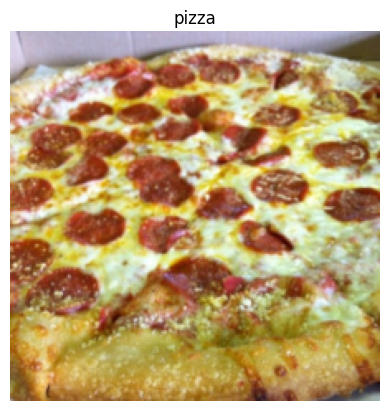

In [12]:
### 4.2 Turning a single image into patches
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [13]:
image.shape

torch.Size([3, 224, 224])

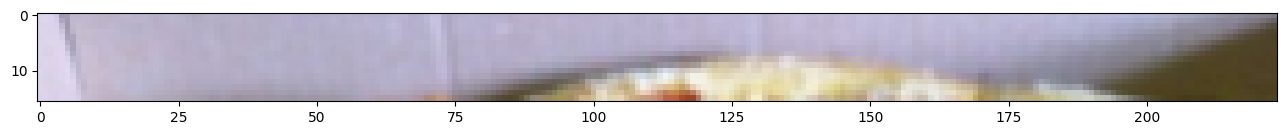

In [14]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # convert image to cc last (H,W,C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


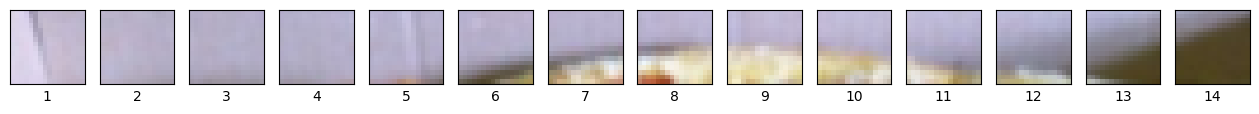

In [15]:
# Setup code to plot row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size, # one columnn per patch
                        sharex=True,
                        sharey=True,
                        figsize = (patch_size,patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


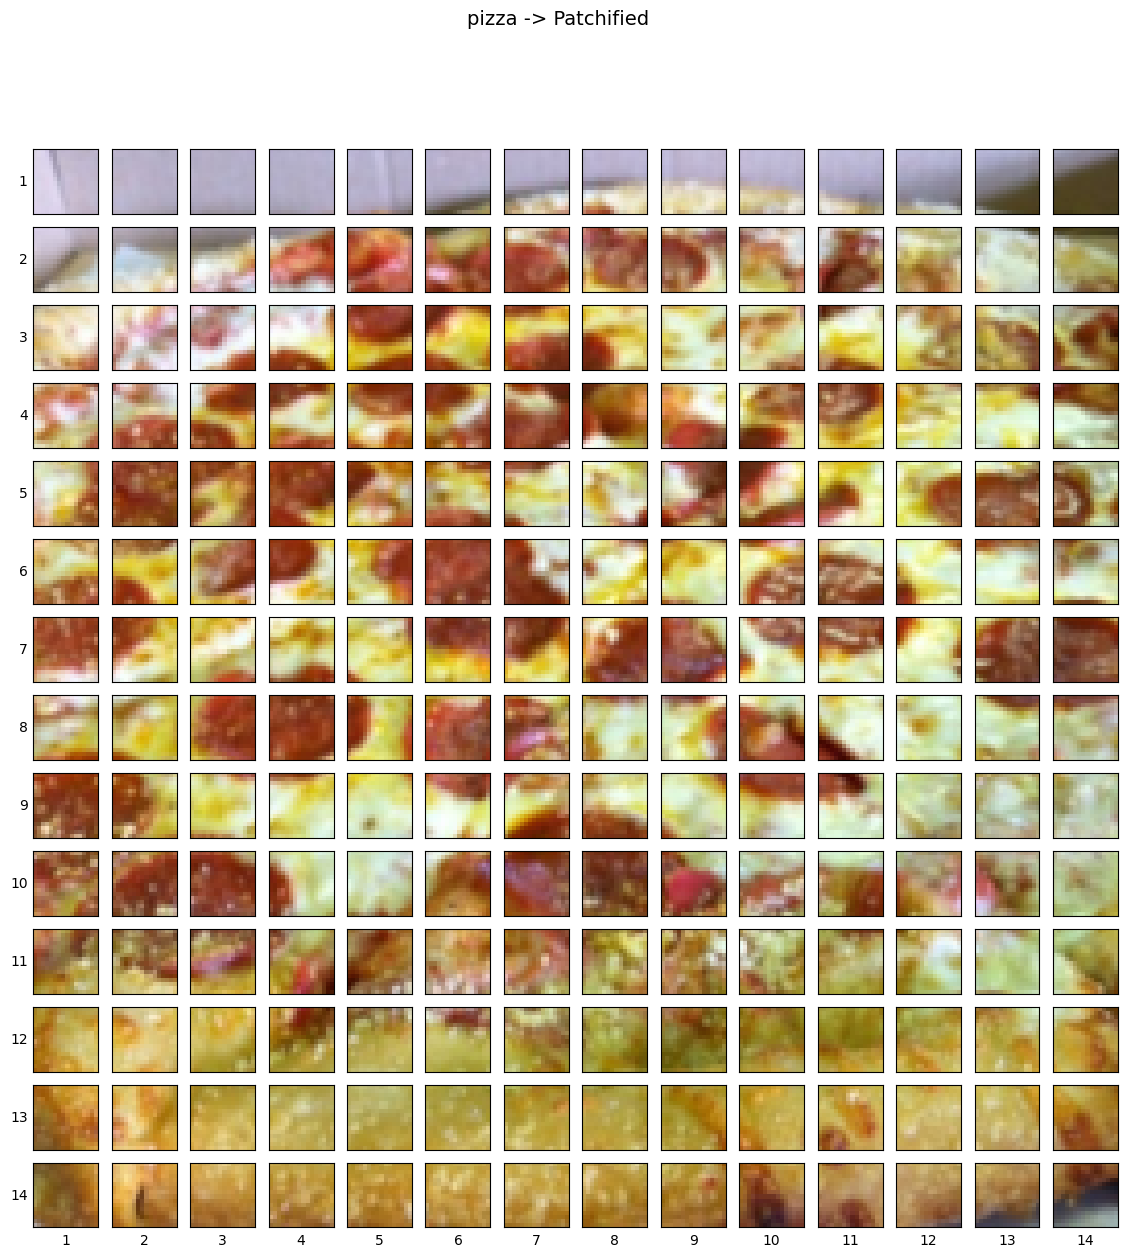

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


### 4.3 Creating patch embeddings

We will create image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [17]:
# Create Conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a Conv2d layer with the hyperparameters from the ViT paper.
conv2d = nn.Conv2d(in_channels = 3, # for color images
                   out_channels = 768, # D size of table 1 of ViT-Base
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

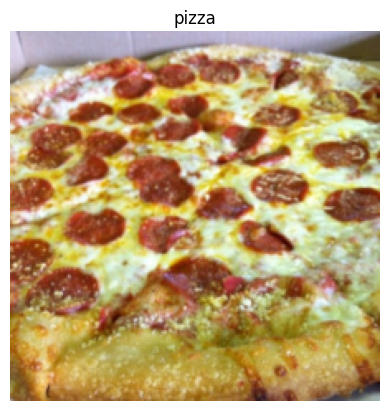

In [18]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [19]:
# Pass the image throug the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add the batch dimension -> (batch_size,color_channels,height,width)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Now we've passed a single image to the `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size,embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [407, 466, 249, 565, 456]


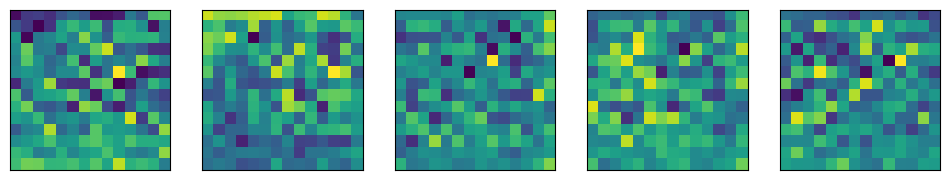

In [20]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12,12))

# Plot random image feature maps
for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension, remove from grad tracking/switch to numpy for matplotlyb
  axs[i].set(xticklabels=[],
             yticklabels=[],
             xticks=[],
             yticks=[])


In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map.shape,single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We want to flatten the patch embeddings into a sequence of patch embeddings to satisfy the criteria of the paper.

Want: (batch_size, number_of_patches, embedding_dim)

In [22]:
# Create a Flatten layer.
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=-1)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


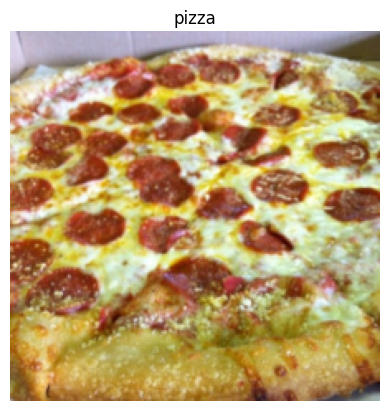

In [23]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [24]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f'{image_out_of_conv_flattened.permute(0,2,1).shape}')

torch.Size([1, 196, 768])


(-0.5, 195.5, 0.5, -0.5)

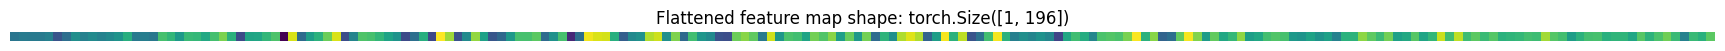

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]

# Plot the flattened feature map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False)


### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define a `forward()` that defines the forward computation
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [26]:
# 1. Create a class PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int = 3,
               patch_size:int = 16,
               embedding_dim:int = 768): # from Table 1 for vit base
    super().__init__()

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels=embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)
    # 4. Create a layer to flatten feature maps outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=-1) #the last dimension

  # 5. Define a forward method to define the forward computation steps
  def forward(self,x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}'

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure the returned sequence embedding dimensions are in the right order
    return x_flattened.permute(0,2,1)


In [27]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim =768)

# Pass a single image through patch embedding layer
print(f'Input Image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra  batch dim
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input Image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [28]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

patchify(rand_image_tensor)


tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating the class token embedding
Want to: Prepend a learnable class token to the start of the patch embedding

In [29]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [30]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size,embedding_dimension

(1, 768)

In [31]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),dim=1)

print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.7680,  0.1752, -0.2406,  ...,  0.6294, -0.3416,  0.3256],
         [-0.7300,  0.1897, -0.1941,  ...,  0.5657, -0.3351,  0.2787],
         ...,
         [-0.5247,  0.0777, -0.0481,  ...,  0.3107, -0.3009,  0.2322],
         [-0.4842,  0.1022, -0.0600,  ...,  0.2693, -0.2533,  0.0841],
         [-0.2437,  0.1199, -0.3064,  ...,  0.2965, -0.1592,  0.0799]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of pathc embeddings.

In [33]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [34]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width)/ patch_size**2)
number_of_patches

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding,position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'patch_and_position_embedding shape : {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.2320, 1.1752, 0.7594,  ..., 1.6294, 0.6584, 1.3256],
         [0.2700, 1.1897, 0.8059,  ..., 1.5657, 0.6649, 1.2787],
         ...,
         [0.4753, 1.0777, 0.9519,  ..., 1.3107, 0.6991, 1.2322],
         [0.5158, 1.1022, 0.9400,  ..., 1.2693, 0.7467, 1.0841],
         [0.7563, 1.1199, 0.6936,  ..., 1.2965, 0.8408, 1.0799]]],
       grad_fn=<AddBackward0>)
patch_and_position_embedding shape : torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding (equation 1)

In [36]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2.Print shapes of the original image tensor and get the image dimensions
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size=patch_size,
                                       embedding_dim = 768)
# 5. Pass input image through PatchEmbedding layer
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

#  6.  Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_simension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad = True) # to make sure it is learnable
print(f'Class token embedding shape: {class_token.shape}')

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding),dim=1)
print(f'Class embedding with class token shape: {patch_embedding_class_token.shape}')

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches + 1,embedding_dimension),
                                  requires_grad = True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Class embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention**: which part of a sequence should pay the most attention ot itself?
  * In our case, we have a series of embedded image patches, which patch  significantly relates to another patch?
  * We want ViT to learn this relationship/representation.
* **LayerNorm**: Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and std.
  * In PyTorch it normalizes values over $D$ dimension, aka the embedding dimension.

In [37]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """ Creates a multi-head self attention block ("MSA block" for short)"""
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1 (Base)
               num_heads:int = 12, # Heads from Table 1 fro ViT-Base
               attn_dropout:int = 0):
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights= False)
    return attn_output

In [38]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768,
                                                             num_heads = 12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through the MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [39]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.2320, 1.1752, 0.7594,  ..., 1.6294, 0.6584, 1.3256],
         [0.2700, 1.1897, 0.8059,  ..., 1.5657, 0.6649, 1.2787],
         ...,
         [0.4753, 1.0777, 0.9519,  ..., 1.3107, 0.6991, 1.2322],
         [0.5158, 1.1022, 0.9400,  ..., 1.2693, 0.7467, 1.0841],
         [0.7563, 1.1199, 0.6936,  ..., 1.2965, 0.8408, 1.0799]]],
       grad_fn=<AddBackward0>)

In [40]:
patched_image_through_msa_block

tensor([[[-0.2237, -0.2613,  0.0372,  ..., -0.4050,  0.8899, -0.4542],
         [-0.2225, -0.2487,  0.0419,  ..., -0.4029,  0.8991, -0.4661],
         [-0.2224, -0.2495,  0.0414,  ..., -0.4031,  0.8992, -0.4662],
         ...,
         [-0.2199, -0.2514,  0.0390,  ..., -0.4038,  0.8983, -0.4657],
         [-0.2198, -0.2527,  0.0380,  ..., -0.4030,  0.8976, -0.4655],
         [-0.2209, -0.2501,  0.0408,  ..., -0.4010,  0.8958, -0.4674]]],
       grad_fn=<TransposeBackward0>)

## 6. Multilayer Perceptron (MLP)

* **MLP** = The MLP contains two layers with a GELU non-linearity
  * MLP =a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  *  Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch they are often called `torch.nn.Linear()` and in Tensorflow `tf.keras.layers.Dense()`
  * GELU in PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP: number of hidden units ( see table 1) = MLP size
  * **Dropout**:  Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.
  * Value for Dropout: in Table 3

  In pseudocode:

  ```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
  ```

In [41]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size: int =3072,
               dropout: int =0.1):
    super().__init__()

    # Create the norm layers (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Create thew MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features = mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    # return self.mlp(self.layer_nornm(x)) faster due to operator fusion
    return x

In [42]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size = 3072,
                     dropout = 0.1)
# Pass the output of the MSA block through the MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [43]:
patched_image_through_msa_block

tensor([[[-0.2237, -0.2613,  0.0372,  ..., -0.4050,  0.8899, -0.4542],
         [-0.2225, -0.2487,  0.0419,  ..., -0.4029,  0.8991, -0.4661],
         [-0.2224, -0.2495,  0.0414,  ..., -0.4031,  0.8992, -0.4662],
         ...,
         [-0.2199, -0.2514,  0.0390,  ..., -0.4038,  0.8983, -0.4657],
         [-0.2198, -0.2527,  0.0380,  ..., -0.4030,  0.8976, -0.4655],
         [-0.2209, -0.2501,  0.0408,  ..., -0.4010,  0.8958, -0.4674]]],
       grad_fn=<TransposeBackward0>)

In [44]:
patched_image_through_mlp_block

tensor([[[-0.0372, -0.0224,  0.2217,  ...,  0.0000, -0.1911,  0.1949],
         [-0.1012, -0.1329,  0.3289,  ..., -0.0710, -0.1531,  0.2089],
         [ 0.0078, -0.0579,  0.3448,  ..., -0.0000, -0.2196,  0.2026],
         ...,
         [-0.1786, -0.0291,  0.3351,  ...,  0.1421, -0.2298,  0.2898],
         [-0.1069,  0.0318,  0.0000,  ...,  0.0749, -0.2013,  0.0816],
         [-0.0607, -0.0378,  0.2901,  ..., -0.0924, -0.1897,  0.1765]]],
       grad_fn=<MulBackward0>)

## 7. Create a PyTorch class for the transformer encoder

The Transformer Encoder is a combination of alternating blocks of MLP(eq 3) and MSA (eq 2).

And there are residual connection between the blocks.

* Encoder = turn a sequence (in our case of image patches) into a learnable representation.
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small).

In pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_outpu +x_input] -> MLP_block -> [MLP_block_output +MSA_block_output + x_input]
```

### 7.1  Create a custom Transformer Encoder block

In [45]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int = 768, # Hidden size D from Table 1, ViT-Base
               num_heads:int = 12, # from table 1
               mlp_size = 3072, #from table 1,
               mlp_dropout:int=0.1, # from table 3,
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    # Create MLP block
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self,x):
    x = self.msa_block(x) + x # residual connection /skip connection for equation 2
    x = self.mlp_block(x) + x # residual/ skip connection for equation 3
    return x


In [46]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary  with torchinfo.summary
summary(model = transformer_encoder_block,
        input_size = (1,197,768), # (batch_size, number_of_patches, embedding_dimension)
        col_names =['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

PyTorch has implemented ready-to-use Transformer Encoder layers:

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

In [47]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [48]:
# Get a summary  with torchinfo.summary
summary(model = torch_transformer_encoder_layer,
        input_size = (1,197,768), # (batch_size, number_of_patches, embedding_dimension)
        col_names =['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT


In [54]:
class ViT(nn.Module):
  def __init__(self,
               img_size:int = 224, # Table 3 from the paper
               in_channels:int = 3,
               patch_size:int = 16,
               num_transformer_layers:int = 12, # Table 1 for "layers" for ViT-Base
               embedding_dim:int = 768, # Hidden size D from Table 1
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int = 0,
               mlp_dropout:float = 0.1,
               embedding_dropout:float = 0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes for classification problem
    super().__init__()

    # Make an assertion  that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f'Image size muszt be divisible by patch size, image: {img_size}, patch size: {patch_size}'

    # Calculate the number of patches (height * width / patch ^ 2)
    self.num_patches = (img_size * img_size) // patch_size ** 2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.rand(1,1,embedding_dim),requires_grad = True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.rand(1,1,embedding_dim),requires_grad = True)

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create the patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size = mlp_size,
                                                                       mlp_dropout = mlp_dropout)for _ in range(num_transformer_layers)]) # using the * symbol we turn all the layers on a stack (one on top of each other)
    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes )
    )
  def forward(self,x):
    batch_size = x.shape[0]
    # Create the class token embedding and expand it to match the batch size (eq 1)
    class_token = self.class_embedding.expand(batch_size,-1,-1) # -1 means to infer the dimensions
    x = self.patch_embedding(x)

    #Concat class token embedding and patch embedding (eq 1)
    x = torch.cat((class_token,x),dim=1) # (batch_size, number_of_patches,embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Add the patch embedding dropout
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to the transformer block (eq 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through the classifier (eq 4)
    x = self.classifier(x[:,0])

    return x


In [57]:
# Create a random image tensor with same shape as single image
random_image_tensor = torch.randn(1,3,224,224)

# Create an instance of ViT with the number of classes we are working with (3)
vit = ViT(num_classes = 3)
vit(random_image_tensor)


tensor([[-0.8369, -0.3467,  0.1328]], grad_fn=<AddmmBackward0>)

In [60]:
### 8.1 Getting a summary of ViT
from torchinfo import summary

summary(model = vit,
        input_size = (1,3,224,224), # (batch_size, color_channels,width,height)
        col_names =['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               1,536                True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 